# Chapter 4

## Set Up

### Packages

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.interpolate import BSpline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## 4.3 Gaussian model of height

### 4.3.1 The data

In [5]:
# load data
howell = load_data(HOWELL_FILE, delimiter=";")

# get adult heights
height = howell.loc[howell["age"] >= 18, "height"].values

Plot the distribution

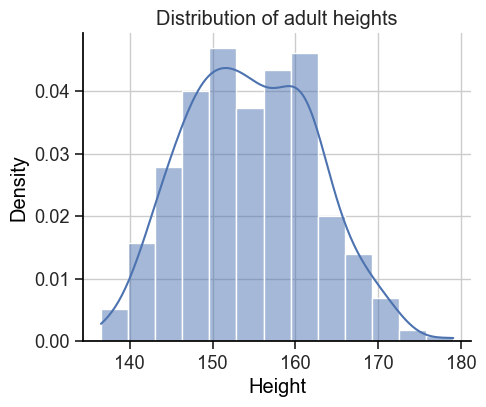

In [6]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.histplot(height, kde=True, stat="density")

ax.set(
    xlabel="Height",
    title="Distribution of adult heights",
);

### 4.3.2 The model

Set and plot priors

In [7]:
def plot_priors(priors):
    n_priors = len(priors)

    ax_width = 6
    width = ax_width * n_priors

    fig, axs = plt.subplots(ncols=n_priors, figsize=(width, 4))

    for ax, (name, prior) in zip(axs, priors.items()):
        x_min, x_max = prior.ppf([0.001, 0.999])
        x_plot = np.linspace(x_min, x_max, 1000)
        y_plot = prior.pdf(x_plot)

        ax.plot(x_plot, y_plot)

        ax.set(ylabel="Density", title=name)

    fig.suptitle("Prior Density Functions")

    return fig, axs

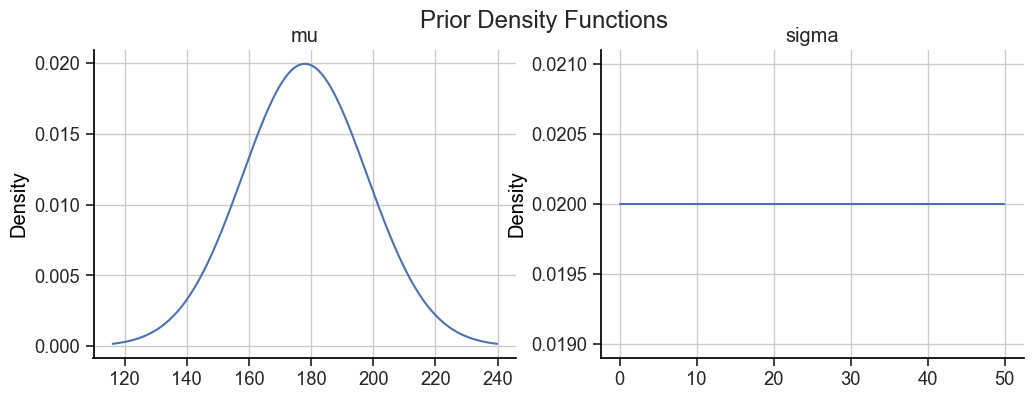

In [8]:
# priors
mu_prior = stats.norm(loc=178, scale=20)
sigma_prior = stats.uniform(0, 50)

priors = {
    "mu": mu_prior,
    "sigma": sigma_prior,
}
plot_priors(priors);

Plot the prior predictive

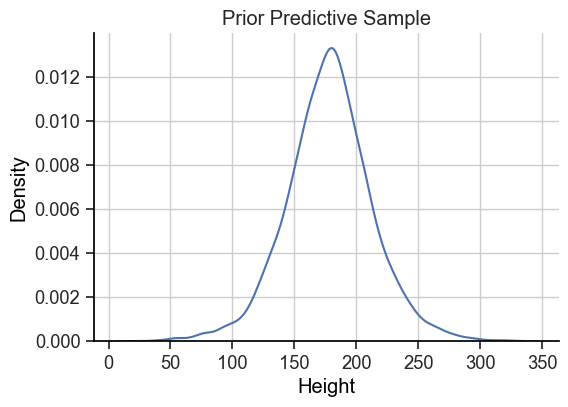

In [9]:
n_sample = 10000
mu_sample = mu_prior.rvs(n_sample)
sigma_sample = sigma_prior.rvs(n_sample)

prior_pred_sample = stats.norm.rvs(loc=mu_sample, scale=sigma_sample, size=n_sample)

# plot distribution
fig, ax = plt.subplots(figsize=(6, 4))

sns.kdeplot(prior_pred_sample, ax=ax)

ax.set(xlabel="Height", title="Prior Predictive Sample");

### 4.3.3 Grid approximation of the posterior distribution

In [10]:
def calculate_height_posterior_with_grid_approximation(
    height, mu_range, mu_prior, sigma_range, sigma_prior
):
    # take cross-product to get grids of pairs
    mu_grid, sigma_grid = np.meshgrid(mu_range, sigma_range)

    # get total log likelihood by taking sum of log likelihoods for each observation
    log_likelihood = np.array(
        [
            stats.norm.logpdf(height[i], loc=mu_grid, scale=sigma_grid)
            for i in range(len(height))
        ]
    ).sum(axis=0)

    # get log prior values at grid points
    mu_prior_log_val = mu_prior.logpdf(mu_grid)
    sigma_prior_log_val = sigma_prior.logpdf(sigma_grid)

    # update prior in log world
    log_posterior = log_likelihood + mu_prior_log_val + sigma_prior_log_val

    # get posterior
    posterior = np.exp(log_posterior - np.max(log_posterior))
    posterior /= posterior.sum()

    return posterior, mu_grid, sigma_grid

In [11]:
mu_range = np.linspace(150, 169, 100)
sigma_range = np.linspace(7, 9, 100)

posterior, mu_grid, sigma_grid = calculate_height_posterior_with_grid_approximation(
    height, mu_range, mu_prior, sigma_range, sigma_prior
)

Plot joint distribution of posterior

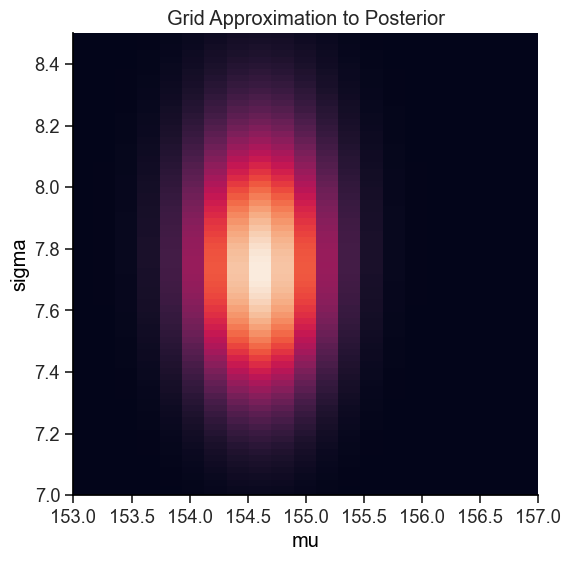

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.pcolormesh(mu_grid, sigma_grid, posterior)

ax.set(
    xlim=[153, 157],
    ylim=[7, 8.5],
    xlabel="mu",
    ylabel="sigma",
    title="Grid Approximation to Posterior",
);

### 4.3.4 Sampling from the posterior

We sample the index of the ravelled grid and use this to sample mu and sigma.

In [13]:
def sample_height_posterior(posterior):
    n_sample = np.prod(posterior.shape)
    grid_ravel_idx = np.arange(n_sample)

    samples_idx = np.random.choice(
        grid_ravel_idx, size=n_sample, p=posterior.ravel(), replace=True
    )

    mu_samples = mu_grid.ravel()[samples_idx]
    sigma_samples = sigma_grid.ravel()[samples_idx]

    return mu_samples, sigma_samples

In [14]:
mu_samples, sigma_samples = sample_height_posterior(posterior)

Plot the posterior sample

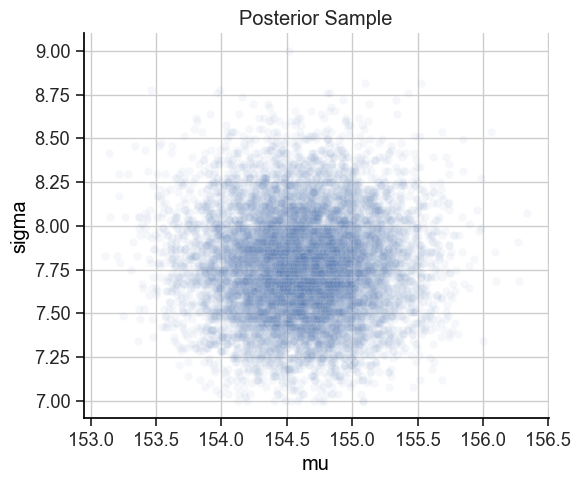

In [15]:
fig, ax = plt.subplots(figsize=(6, 5))

# add some jitter or the points are all on top of each other
mu_jitter_std = 0.1
mu_jitter = stats.norm.rvs(loc=0, scale=mu_jitter_std, size=len(mu_samples))

sns.scatterplot(
    x=mu_samples + mu_jitter,
    y=sigma_samples,
    alpha=0.05,
    ax=ax,
)

ax.set(
    xlabel="mu",
    ylabel="sigma",
    title="Posterior Sample",
);

We can also plot a joint density plot

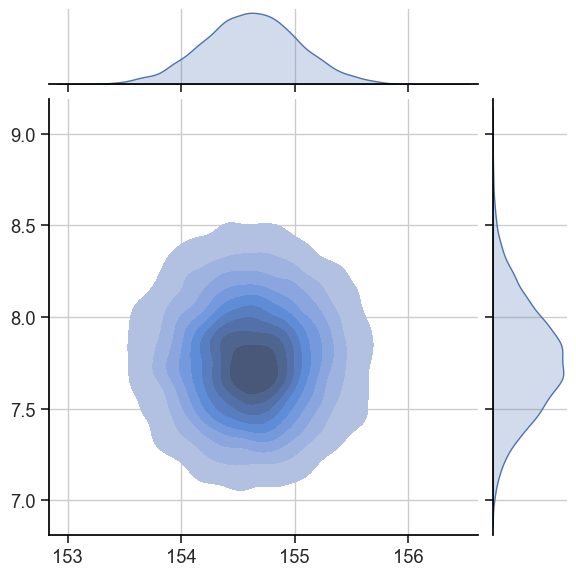

In [16]:
sns.jointplot(
    x=mu_samples + mu_jitter,
    y=sigma_samples,
    kind="kde",
    fill=True,
);

Try repeating the above with less data

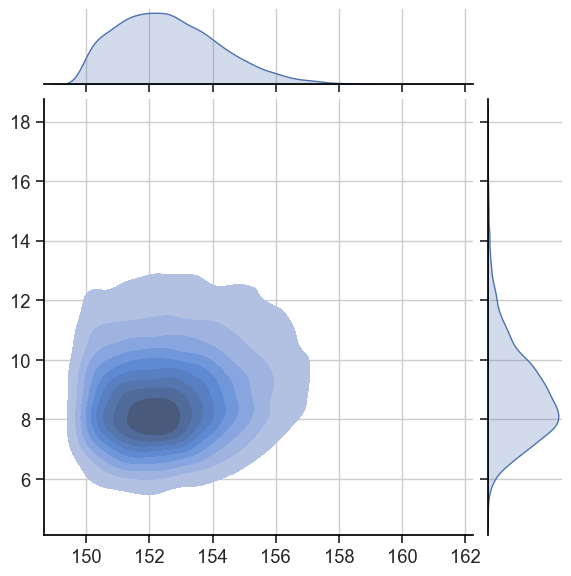

In [17]:
mu_range = np.linspace(150, 170, 100)
sigma_range = np.linspace(4, 20, 100)

height_sample = np.random.choice(height, size=20, replace=False)
posterior, mu_grid, sigma_grid = calculate_height_posterior_with_grid_approximation(
    height_sample, mu_range, mu_prior, sigma_range, sigma_prior
)

mu_samples, sigma_samples = sample_height_posterior(posterior)

sns.jointplot(
    x=mu_samples + mu_jitter,
    y=sigma_samples,
    kind="kde",
    fill=True,
);

The posterior is a lot wider and the parameter $\sigma$ is a lot less normal - it has a long tail.

### 4.3.5 Finding the posterior distribution with `quap`

Now let's try generating the posterior using PyMC, since we don't have a package to do quadratic approximation

In [18]:
# load data
howell = load_data(HOWELL_FILE, delimiter=";")

# get adult heights
data = howell.loc[howell["age"] >= 18, "height"]

In [19]:
with pm.Model() as m4_1:
    # stochastic random variables (priors)
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # observed stochastic (likelihood)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data)

    # draw 1000 posterior samples
    # returns InferenceData object
    trace_4_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Get summary stats for the posterior distributions

In [20]:
az.summary(trace_4_1, kind="stats", hdi_prob=0.89, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.61,0.41,153.98,155.26
sigma,7.77,0.29,7.28,8.20


Try more informative priors:

In [21]:
with pm.Model() as m4_2:
    # stochastic random variables (priors)
    mu = pm.Normal("mu", mu=178, sigma=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # observed stochastic (likelihood)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data)

    # draw 1000 posterior samples
    trace_4_2 = pm.sample()

az.summary(trace_4_2, kind="stats", hdi_prob=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
mu,177.86,0.10,177.69,178.02
sigma,24.60,0.94,23.15,26.09


## 4.4 Linear prediction

Plot height against weight.

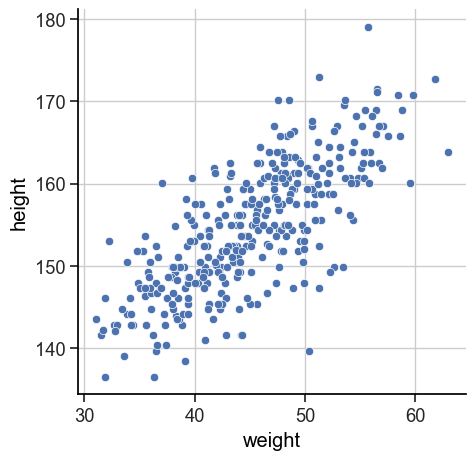

In [22]:
# load data
howell = load_data(HOWELL_FILE, delimiter=";")
adult = howell.loc[howell["age"] >= 18, :]

# plot height against weight
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(adult, x="weight", y="height", ax=ax);

### 4.4.1 The linear model strategy

Simulate linear relationships by sampling priors

In [23]:
def plot_linear_weight_model_prior_predictive_manual(
    adult, alpha_prior, beta_prior, n_draw=100, ax=None
):
    # sample the priors
    alpha_sample = alpha_prior.rvs(size=n_draw)
    beta_sample = beta_prior.rvs(size=n_draw)

    weights = adult.weight.values

    # coerce into shapes (n_weight, n_draw)
    alpha_grid, weights_grid = np.meshgrid(alpha_sample, weights)
    beta_grid, _ = np.meshgrid(beta_sample, weights)

    heights_grid = alpha_grid + beta_grid * (weights_grid - weights_grid.mean(axis=0))

    # plot the data
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    for draw in range(n_draw):
        ax.plot(
            weights_grid[:, draw], heights_grid[:, draw], color="k", lw=0.2, alpha=0.5
        )

    ax.axhline(0, ls="--", lw=0.8, color="k")
    ax.axhline(272, lw=0.8, color="k")

    ax.set(
        ylim=[-100, 400],
        xlabel="weight",
        ylabel="height",
    )

Try it out with two different priors for the slope beta.

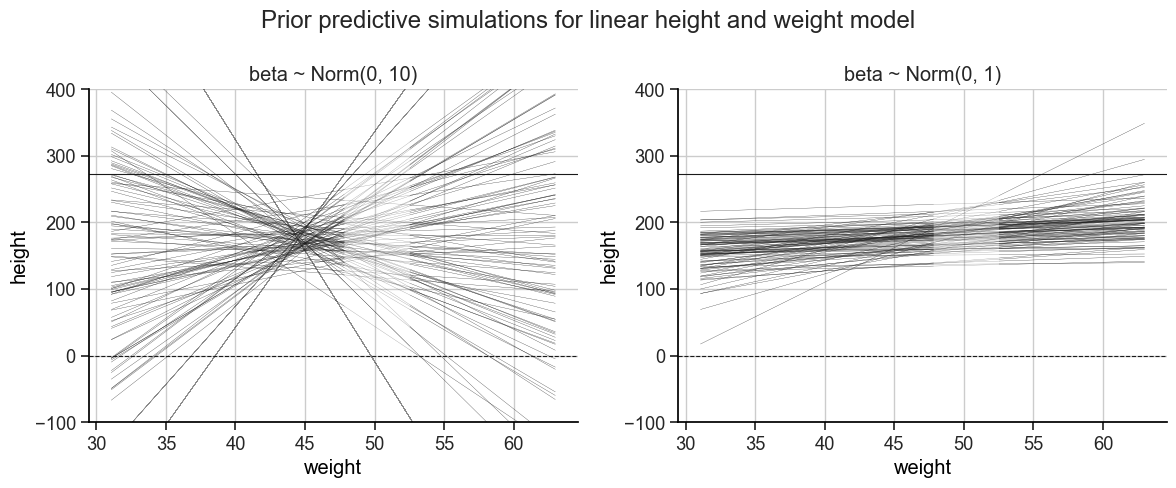

In [24]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

alpha_prior = stats.norm(loc=178, scale=20)
beta_prior_0 = stats.norm(loc=0, scale=10)
beta_prior_1 = stats.lognorm(s=1)

plot_linear_weight_model_prior_predictive_manual(
    adult, alpha_prior, beta_prior_0, ax=ax0
)
plot_linear_weight_model_prior_predictive_manual(
    adult, alpha_prior, beta_prior_1, ax=ax1
)

ax0.set(title="beta ~ Norm(0, 10)")
ax1.set(title="beta ~ Norm(0, 1)")

fig.suptitle("Prior predictive simulations for linear height and weight model")
plt.tight_layout();

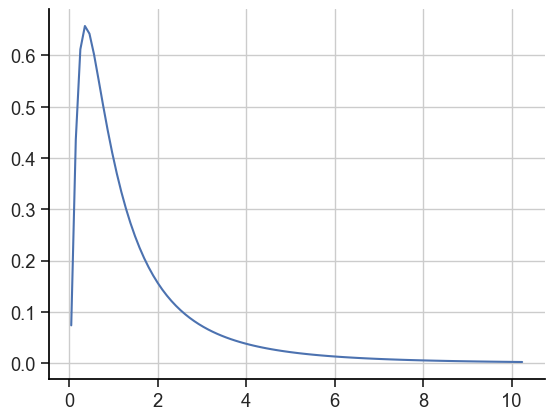

In [25]:
x_plot = np.linspace(beta_prior_1.ppf(0.001), beta_prior_1.ppf(0.99), 100)
y_plot = beta_prior_1.pdf(x_plot)
plt.plot(x_plot, y_plot)

We can do this in PyMC instead.

In [26]:
def plot_linear_weight_model_prior_predictive_pymc(
    adult,
    alpha_prior_kwargs,
    beta_prior_kwargs,
    beta_prior_dist="norm",
    n_draw=100,
    ax=None,
):
    weight = adult.weight
    weight_scaled = weight - weight.mean()

    with pm.Model():
        # priors
        alpha = pm.Normal("alpha", **alpha_prior_kwargs)
        if beta_prior_dist == "norm":
            beta = pm.Normal("beta", **beta_prior_kwargs)
        elif beta_prior_dist == "log_norm":
            beta = pm.LogNormal("beta", **beta_prior_kwargs)
        else:
            raise ValueError("Beta must have either 'norm' or 'log_norm' distribution")

        # in the example sigma is 0 - we approximate this with a very tight prior
        sigma = pm.Uniform("sigma", lower=0, upper=0.1)

        # deterministic
        mu = alpha + beta * weight_scaled

        # observed
        height = pm.Normal("height", mu=mu, sigma=sigma, observed=adult.height)

        trace = pm.sample_prior_predictive(samples=n_draw, random_seed=RANDOM_SEED)

    # get the prior predictive
    prior_pred = trace.prior_predictive

    # plot the data
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    for draw in range(n_draw):
        ax.plot(
            weight,
            prior_pred.height.sel(chain=0, draw=draw),
            color="k",
            lw=0.2,
            alpha=0.5,
        )

    ax.axhline(0, ls="--", lw=0.8, color="k")
    ax.axhline(272, lw=0.8, color="k")

    ax.set(
        ylim=[-100, 400],
        xlabel="weight",
        ylabel="height",
    )

Sampling: [alpha, beta, height, sigma]
Sampling: [alpha, beta, height, sigma]


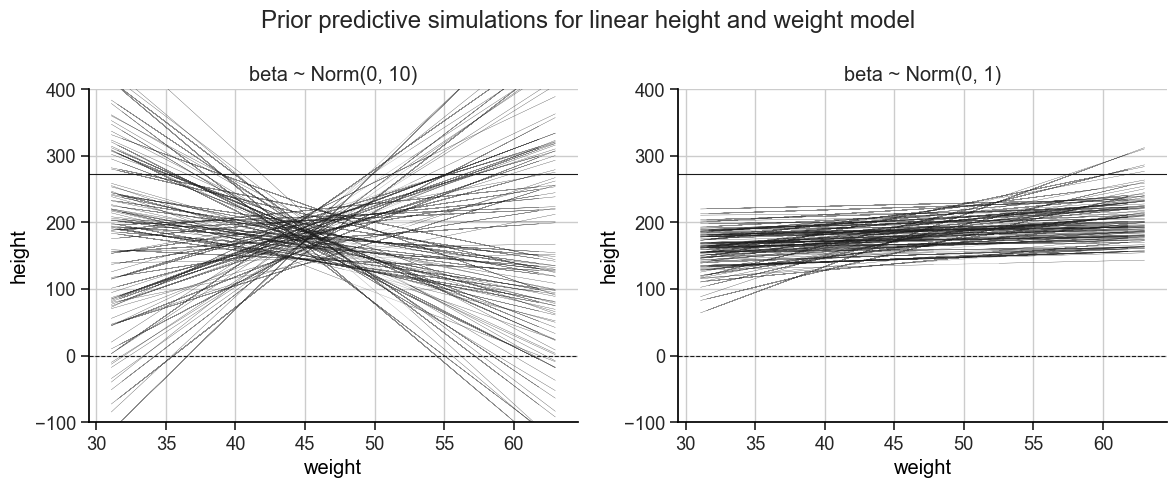

In [27]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

alpha_prior_kwargs = {"mu": 178, "sigma": 20}
beta_prior_kwargs_0 = {"mu": 0, "sigma": 10}
beta_prior_kwargs_1 = {"mu": 0, "sigma": 1}

plot_linear_weight_model_prior_predictive_pymc(
    adult, alpha_prior_kwargs, beta_prior_kwargs_0, ax=ax0
)
plot_linear_weight_model_prior_predictive_pymc(
    adult, alpha_prior_kwargs, beta_prior_kwargs_1, beta_prior_dist="log_norm", ax=ax1
)

ax0.set(title="beta ~ Norm(0, 10)")
ax1.set(title="beta ~ Norm(0, 1)")

fig.suptitle("Prior predictive simulations for linear height and weight model")
plt.tight_layout();

### 4.4.2 Finding the posterior distribution

In [28]:
# reload the data
howell = load_data(HOWELL_FILE, delimiter=";")
adult = howell.loc[howell["age"] >= 18, :]

Specify the model and sample the posterior

In [29]:
with pm.Model() as m4_3:
    # priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.LogNormal("beta", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # data
    weight = pm.MutableData("weight", adult.weight)

    # deterministic
    mu = pm.Deterministic("mu", alpha + beta * (weight - weight.mean()))

    # observed
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=adult.height)

    # sample posterior
    trace_4_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### 4.4.3 Interpreting the posterior distribution

Summarise the posterior distributions

In [30]:
az.summary(
    trace_4_3,
    var_names=["alpha", "beta", "sigma"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,154.61,0.26,154.19,155.03
beta,0.90,0.04,0.83,0.97
sigma,5.11,0.19,4.80,5.41


Get covariance. Annoying we have to remove the extra dimensions coming from weight and mu.

In [31]:
trace_df = trace_4_3.posterior.drop("mu").mean(dim=["mu_dim_0"]).to_dataframe()
trace_df

alpha      beta     sigma
chain draw                                
0     0     155.111533  0.941493  5.398172
      1     154.821811  0.936651  5.342088
      2     154.630749  0.892685  5.100177
      3     154.496542  0.932548  5.144493
      4     154.474965  0.871163  4.963780
...                ...       ...       ...
3     995   154.700120  0.860401  5.214460
      996   154.655974  0.985503  5.093872
      997   154.534695  0.825457  5.107159
      998   154.450857  0.817907  5.204670
      999   155.258372  0.898880  5.063955

[4000 rows x 3 columns]

Note that this is actually 1000 draws from 4 different chains. We could restrict to a single chain, but it doesn't really matter.

In [32]:
trace_df.cov().round(3)

,alpha,beta,sigma
alpha,0.069,0.000,0.000
beta,0.000,0.002,0.000
sigma,0.000,0.000,0.037


Now plot the regression line arising from the posterior means

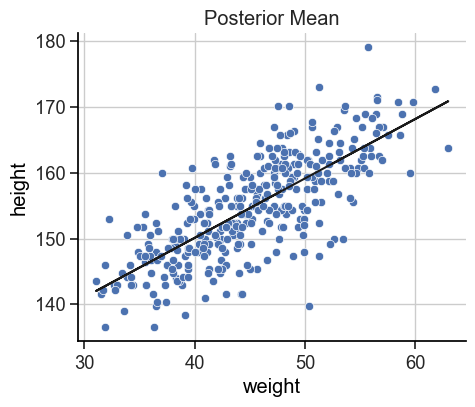

In [33]:
fig, ax = plt.subplots(figsize=(5, 4))

# plot data
sns.scatterplot(adult, x="weight", y="height", ax=ax)

alpha_mean = trace_4_3.posterior.alpha.mean().item(0)
beta_mean = trace_4_3.posterior.beta.mean().item(0)

weight = trace_4_3.constant_data.weight
height_est = alpha_mean + beta_mean * (weight - weight.mean())

ax.plot(weight, height_est, color="k")

ax.set(title="Posterior Mean");

Now sample the posterior and plot the resulting lines against the actual data.

In [34]:
def plot_posterior_lines(adult, n_samples=None, n_lines=20, ax=None):
    if not n_samples:
        n_samples = adult.shape[0]

    with pm.Model():
        # priors
        alpha = pm.Normal("alpha", **alpha_prior_kwargs)
        beta = pm.LogNormal("beta", mu=0, sigma=1)
        sigma = pm.Uniform("sigma", lower=0, upper=50)

        # data
        weight = pm.MutableData("weight", adult.weight.iloc[:n_samples])
        weight_scaled = pm.Deterministic("weight_scaled", weight - weight.mean())

        # deterministic
        mu = pm.Deterministic("mu", alpha + beta * weight_scaled)

        # observed
        height = pm.Normal(
            "height", mu=mu, sigma=sigma, observed=adult.height.iloc[:n_samples]
        )

        # sample posterior
        trace = pm.sample(1000)

    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    # plot data
    sns.scatterplot(adult.iloc[:n_samples], x="weight", y="height", ax=ax)

    for draw in range(n_lines):
        ax.plot(
            trace.constant_data.weight,
            trace.posterior.mu.sel(chain=0, draw=draw),
            color="k",
            lw=0.2,
            alpha=0.5,
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


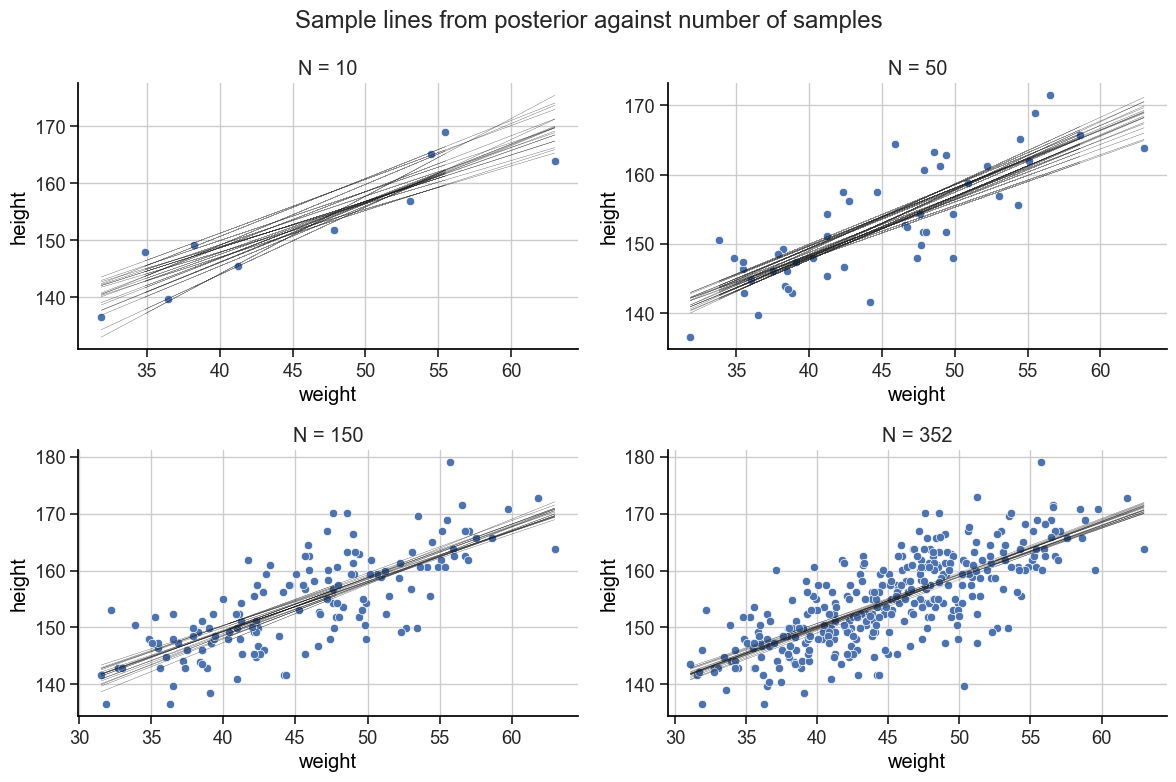

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

n_samples_list = [10, 50, 150, 352]

axs_ravel = axs.ravel()
for n_samples, ax in zip(n_samples_list, axs_ravel):
    plot_posterior_lines(adult, n_samples=n_samples, ax=ax)
    ax.set(title=f"N = {n_samples}")

fig.suptitle("Sample lines from posterior against number of samples")
fig.tight_layout();

Let's plot the distribution of $\mu$ for fixed weight=50

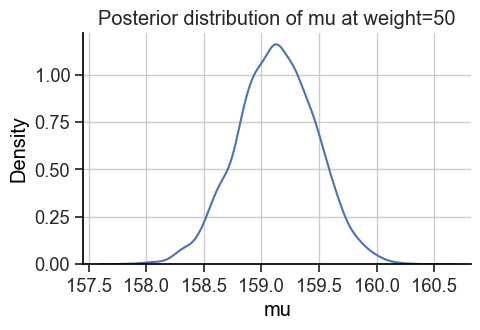

In [36]:
# combine everything into a single sample for each param
data_4_3 = az.extract(trace_4_3)

# calculate mu
weight = trace_4_3.constant_data.weight
mu_at_50 = data_4_3.alpha + data_4_3.beta * (50 - weight.mean())

# plot
fig, ax = plt.subplots(figsize=(5, 3))

sns.kdeplot(mu_at_50, ax=ax)

ax.set(xlabel="mu", title="Posterior distribution of mu at weight=50");

In [37]:
# percentile interval
print(az.hdi(mu_at_50.values, hdi_prob=0.89).round(2))

[158.57 159.65]


We can also plot a HDI around the regression line

In [38]:
mu_hdi = az.hdi(trace_4_3.posterior.mu, hdi_prob=0.89)
mu_hdi

<xarray.Dataset>
Dimensions:   (mu_dim_0: 352, hdi: 2)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 345 346 347 348 349 350 351
  * hdi       (hdi) <U6 'lower' 'higher'
Data variables:
    mu        (mu_dim_0, hdi) float64 156.7 157.6 146.2 ... 163.6 160.8 162.1

To get the mean values we can just average over all chains and draws

In [39]:
mu_mean = trace_4_3.posterior.mu.mean(dim=["chain", "draw"])
mu_mean

<xarray.DataArray 'mu' (mu_dim_0: 352)>
array([157.16769744, 146.92270388, 142.747869  , 161.88039448,
       151.25121366, 170.87037633, 148.51067788, 164.08306809,
       145.4627923 , 163.18663116, 159.03740877, 151.19998869,
       146.51290414, 157.05421768, 144.54074288, 157.83362202,
       152.19887556, 148.61312782, 158.21780928, 152.55745034,
       146.02626694, 148.20332807, 146.00065446, 150.38038921,
       163.7501058 , 147.8447533 , 148.74119024, 156.06636063,
       149.04854004, 146.10310439, 156.78351018, 157.21892241,
       158.60199654, 158.57638406, 165.05634248, 149.30466488,
       159.03740877, 151.22560118, 148.7924152 , 152.26590873,
       154.29909924, 166.90044132, 156.16881057, 153.91491198,
       159.94527214, 163.03295625, 155.42604854, 157.34698483,
       161.13763245, 156.98841005, 155.19553618, 152.27571302,
       146.92270388, 164.49286784, 147.56301598, 157.60310967,
       147.6910784 , 156.57861031, 156.68106025, 165.95277942,
       148.22894056, 156.60422279, 152.99286256, 159.37037106,
       149.53517724, 159.75464324, 149.58640221, 146.74341649,
       155.75901083, 152.1476506 , 156.98841005, 164.28796797,
       157.83362202, 152.63428779, 145.64207968, 165.23562987,
       160.26680799, 156.62983528, 150.94386385, 143.51624352,
...
       160.06190812, 150.79018895, 147.89597827, 160.5741578 ,
       154.45277415, 153.17214995, 156.16881057, 149.68885214,
       145.38595484, 149.45833979, 147.79352833, 157.93607196,
       146.12871688, 153.45388727, 157.50065973, 160.01068315,
       153.71001211, 157.50065973, 156.14319808, 164.92828006,
       157.85923451, 157.52627222, 156.86034763, 146.07749191,
       147.02587251, 158.1921968 , 160.26680799, 155.98952318,
       147.35811611, 157.91045947, 148.33139049, 156.68106025,
       164.00623064, 162.93050632, 157.75678457, 152.86480014,
       144.84809268, 159.08863373, 154.01736192, 144.1821681 ,
       156.68106025, 155.63094841, 156.78351018, 150.8670264 ,
       159.44720851, 154.73451147, 152.12203811, 151.58417595,
       154.81134892, 160.26680799, 158.47393412, 160.21558303,
       153.58194969, 146.05187943, 152.70446362, 156.22003554,
       151.78907582, 148.47139974, 153.07901779, 162.41825664,
       152.78796269, 149.89375201, 153.12092498, 161.54743219,
       148.68996527, 152.63428779, 146.38484172, 153.91491198,
       148.35700298, 153.81246205, 153.7356246 , 157.21892241,
       149.56078972, 151.04631379, 150.84141392, 156.45054789,
       144.89931765, 161.08640748, 162.8024439 , 161.41936977])
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 345 346 347 348 349 350 351

We need to order by weight in the plot so it's convenient to collect all the data into a dataframe.

In [40]:
mu_plot_data = pd.DataFrame(
    {
        "weight": trace_4_3.constant_data.weight,
        "mean": mu_mean,
        "hdi_lower": mu_hdi.mu.sel(hdi="lower"),
        "hdi_higher": mu_hdi.mu.sel(hdi="higher"),
    }
).sort_values("weight")

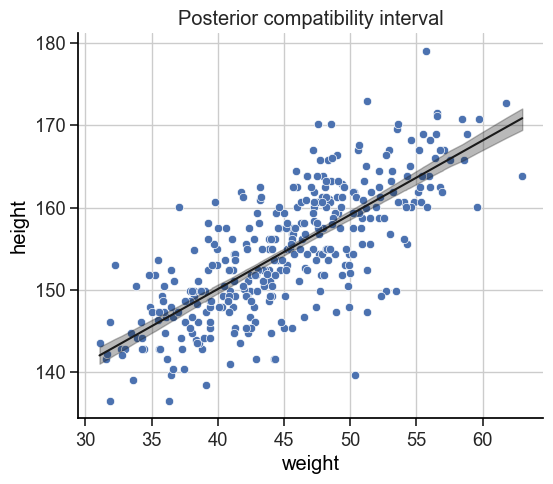

In [41]:
fig, ax = plt.subplots(figsize=(6, 5))

# plot true data
sns.scatterplot(adult.iloc[:n_samples], x="weight", y="height", ax=ax)

# plot the mean at each weight
ax.plot(mu_plot_data["weight"], mu_plot_data["mean"], color="k")

ax.fill_between(
    mu_plot_data["weight"],
    mu_plot_data["hdi_lower"],
    mu_plot_data["hdi_higher"],
    color="k",
    alpha=0.3,
)

ax.set(title="Posterior compatibility interval");

We add in the uncertainty coming from $\mu$ by taking a posterior predictive sample and constructing an HDI at each weight value

In [42]:
with m4_3:
    post_pred_sample = pm.sample_posterior_predictive(trace_4_3)

Sampling: [height]


In [43]:
height_hdi = az.hdi(post_pred_sample.posterior_predictive.height, hdi_prob=0.89)
post_pred_plot_data = pd.DataFrame(
    {
        "weight": trace_4_3.constant_data.weight,
        "hdi_lower": height_hdi.height.sel(hdi="lower"),
        "hdi_higher": height_hdi.height.sel(hdi="higher"),
    }
).sort_values("weight")

Now add this to the plot above

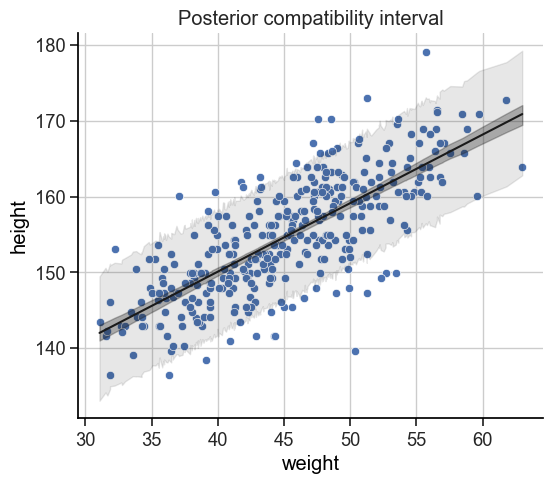

In [44]:
fig, ax = plt.subplots(figsize=(6, 5))

# plot true data
sns.scatterplot(adult.iloc[:n_samples], x="weight", y="height", ax=ax)

# plot the mean at each weight
ax.plot(mu_plot_data["weight"], mu_plot_data["mean"], color="k")

# mu HDI
ax.fill_between(
    mu_plot_data["weight"],
    mu_plot_data["hdi_lower"],
    mu_plot_data["hdi_higher"],
    color="k",
    alpha=0.3,
)

# posterior predictive HDI
ax.fill_between(
    post_pred_plot_data["weight"],
    post_pred_plot_data["hdi_lower"],
    post_pred_plot_data["hdi_higher"],
    color="k",
    alpha=0.1,
)

ax.set(title="Posterior compatibility interval");

## 4.5 Curves from lines

### 4.5.1 Polynomial regression

Plot the full height and weight data

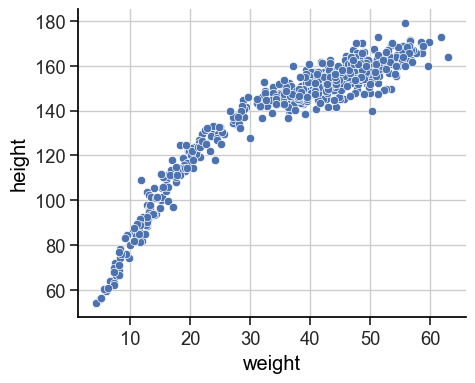

In [45]:
# reload the data
howell = load_data(HOWELL_FILE, delimiter=";")

# plot
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(howell, x="weight", y="height", ax=ax);

Standardise weight and add polynomial features

In [46]:
# standardise weight
howell["weight_std"] = (howell["weight"] - howell["weight"].mean()) / howell[
    "weight"
].std()
howell["weight_std_sq"] = howell["weight_std"] ** 2
howell["weight_std_cub"] = howell["weight_std"] ** 3

In [47]:
with pm.Model() as m4_5:
    # priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta1 = pm.LogNormal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # data
    weight = pm.MutableData("weight", howell.weight)
    weight_std = pm.MutableData("weight_std", howell.weight_std)
    weight_std_sq = pm.MutableData("weight_std_sq", howell.weight_std_sq)

    # deterministic
    mu = pm.Deterministic("mu", alpha + beta1 * weight_std + beta2 * weight_std_sq)

    # observed
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=howell.height)

    # sample posterior
    trace_4_5 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [48]:
az.summary(
    trace_4_5,
    var_names="~mu",
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,146.06,0.37,145.43,146.61
beta2,-7.80,0.27,-8.22,-7.36
beta1,21.74,0.29,21.27,22.20
sigma,5.80,0.18,5.52,6.08


Now we plot the mean and a posterior predictive HDI against the data.

In [49]:
def plot_mean_and_posterior_predictive_hdi(model, data, ax=None):
    with model:
        # sample posterior
        trace = pm.sample(1000)

        # sample posterior predictive
        pp_trace = pm.sample_posterior_predictive(trace)

    # get mean of mu
    mu_mean = pd.Series(
        index=trace.constant_data.weight,
        data=trace.posterior.mu.mean(dim=["chain", "draw"]),
    ).sort_index()

    # get posterior predictive hdi
    height_hdi = az.hdi(pp_trace.posterior_predictive.height, hdi_prob=0.89)
    height_hdi = pd.DataFrame(
        {
            "weight": trace.constant_data.weight,
            "hdi_lower": height_hdi.height.sel(hdi="lower"),
            "hdi_higher": height_hdi.height.sel(hdi="higher"),
        }
    ).sort_values("weight")

    # plot
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 5))

    # plot true data
    sns.scatterplot(data, x="weight", y="height", ax=ax)

    # plot the mean at each weight
    ax.plot(mu_mean, color="k")

    # posterior predictive HDI
    ax.fill_between(
        height_hdi["weight"],
        height_hdi["hdi_lower"],
        height_hdi["hdi_higher"],
        color="k",
        alpha=0.1,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [height]


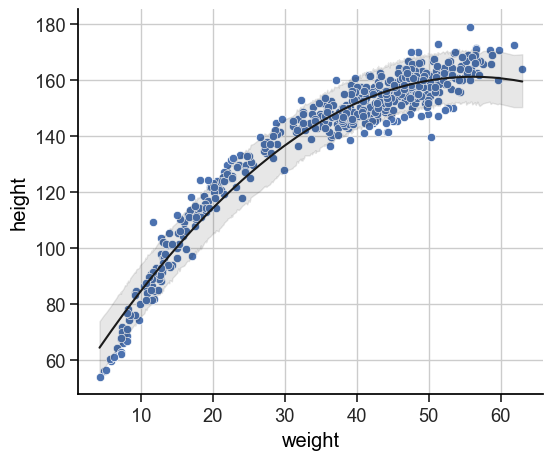

In [50]:
plot_mean_and_posterior_predictive_hdi(m4_5, howell)

In [51]:
# linear model
with pm.Model() as m4_4:
    # priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta1 = pm.LogNormal("beta1", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # data
    weight = pm.MutableData("weight", howell.weight)
    weight_std = pm.MutableData("weight_std", howell.weight_std)

    # deterministic
    mu = pm.Deterministic("mu", alpha + beta1 * weight_std)

    # observed
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=howell.height)


# cubic model
with pm.Model() as m4_6:
    # priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta1 = pm.LogNormal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    beta3 = pm.Normal("beta3", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # data
    weight = pm.MutableData("weight", howell.weight)
    weight_std = pm.MutableData("weight_std", howell.weight_std)
    weight_std_sq = pm.MutableData("weight_std_sq", howell.weight_std_sq)
    weight_std_cub = pm.MutableData("weight_std_cub", howell.weight_std_cub)

    # deterministic
    mu = pm.Deterministic(
        "mu",
        alpha + beta1 * weight_std + beta2 * weight_std_sq + beta3 * weight_std_cub,
    )

    # observed
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=howell.height)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [height]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [height]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [height]


Text(0.5, 0.98, 'Polynomial regression for different orders')

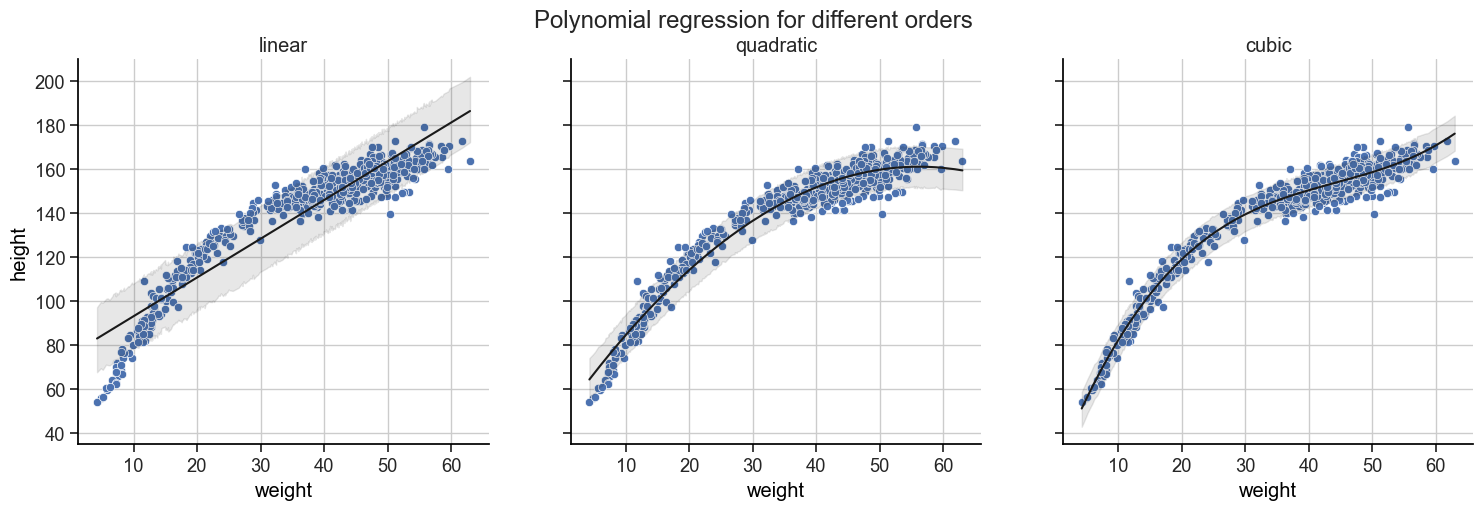

In [52]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(18, 5))

models = {
    "linear": m4_4,
    "quadratic": m4_5,
    "cubic": m4_6,
}
for ax, (name, model) in zip(axs, models.items()):
    plot_mean_and_posterior_predictive_hdi(model, howell, ax=ax)
    ax.set(title=name)

fig.suptitle("Polynomial regression for different orders");

### 4.5.2 Splines

Load the data

In [163]:
cherry = load_data(CHERRY_BLOSSOMS_FILE)

# drop rows missing doy data
cherry = cherry.dropna(subset=["doy"])

cherry.describe()

,year,doy,temp,temp_upper,temp_lower
count,827.000000,827.000000,787.000000,787.000000,787.000000
mean,1548.841596,104.540508,6.100356,6.937560,5.263545
std,304.149774,6.407036,0.683410,0.811986,0.762194
min,812.000000,86.000000,4.690000,5.450000,2.610000
25%,1325.000000,100.000000,5.625000,6.380000,4.770000
50%,1583.000000,105.000000,6.060000,6.800000,5.250000
75%,1803.500000,109.000000,6.460000,7.375000,5.650000
max,2015.000000,124.000000,8.300000,12.100000,7.740000


Plot `doy` against year

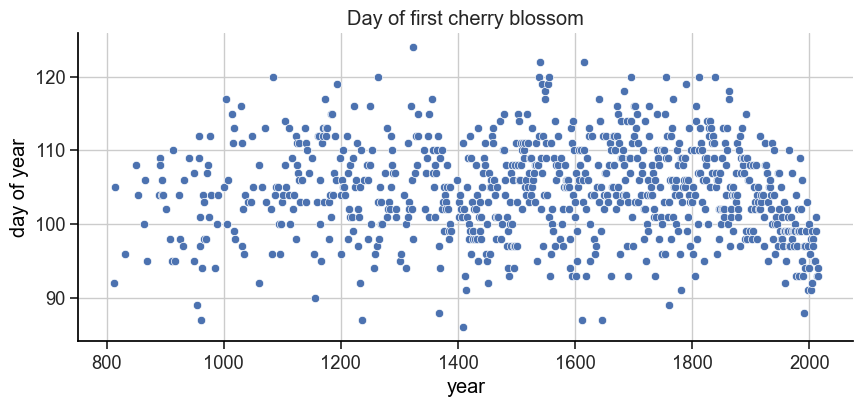

In [54]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.scatterplot(cherry, x="year", y="doy", ax=ax)

ax.set(ylabel="day of year", title="Day of first cherry blossom");

Start with linear splines with 5 knots. The matrix with each basis spline evaluated at each data point is called the 'design matrix'

In [307]:
def generate_design_matrix(cherry, n_knots, deg):
    knots = np.quantile(cherry.year, np.linspace(0, 1, n_knots))

    # add additional endpoint control knots - deg at each endpoint
    start_knots = np.array([cherry.year.min()] * deg)
    end_knots = np.array([cherry.year.max()] * deg)
    knots_ext = np.concatenate([start_knots, knots, end_knots])

    # this brings total knots to n_knots + 2 * deg, so we will have
    n_basis = n_knots + deg - 1

    # use arbitrary weights to start
    splines = BSpline(knots_ext, np.ones(n_basis), deg)

    # design matrix is basis splines evaluated at given points
    design_matrix = splines.design_matrix(cherry.year, knots_ext, deg, extrapolate=True).toarray()
    
    return design_matrix, knots

In [308]:
n_knots = 5
deg = 1

design_matrix, knots = generate_design_matrix(cherry, n_knots, deg)

We plot the individual (unweighted) basis splines

In [309]:
def plot_basis_splines(cherry, design_matrix, knots, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 3))
        
    # plot the basis splines
    n_basis = design_matrix.shape[1]
    for i in range(n_basis):
        ax.plot(cherry.year, design_matrix[:, i])
    
    # plot the knots
    for knot in knots:
        ax.axvline(knot, ls="--", color="k", alpha=0.5)

    ax.set(
        xlabel="year",
        ylabel="basis value",
        title="Basis Splines",
    )

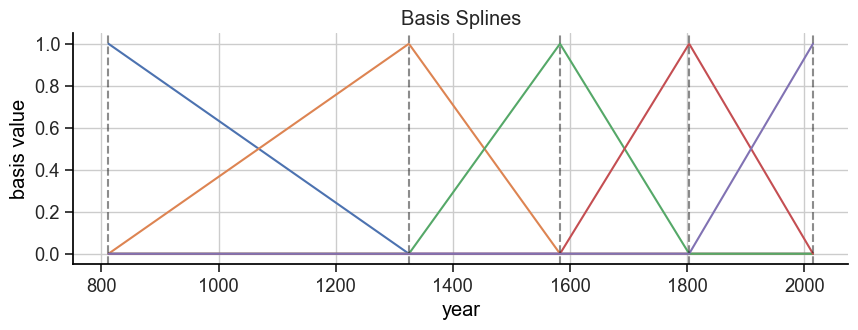

In [310]:
plot_basis_splines(cherry, design_matrix, knots)

Now define a linear model with the basis splines as inputs.

In [ ]:
def define_linear_spline_model(cherry, design_matrix):
    n_basis = design_matrix.shape[1]
    
    with pm.Model() as model:
        # priors
        alpha = pm.Normal("alpha", mu=100, sigma=10)
        beta = pm.Normal("beta", mu=0, sigma=10, shape=n_basis)
        sigma = pm.Exponential("sigma", lam=1)

        # data
        year = pm.MutableData("year", cherry.year)
        year_splines = pm.MutableData("year_splines", design_matrix) # shape is inferred

        # deterministic
        mu = pm.Deterministic(
            "mu",
            alpha + year_splines @ beta
        )

        # observed
        doy = pm.Normal("doy", mu=mu, sigma=sigma, observed=cherry.doy)
    
    return model

In [312]:
m4_7a = define_linear_spline_model(cherry, design_matrix)

with m4_7a:
    trace_4_7a = pm.sample(1000)

az.summary(
    trace_4_7a,
    var_names="~mu",
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_5.5%,hdi_94.5%
alpha,103.09,4.13,96.82,109.80
beta[0],0.05,4.19,-6.30,6.95
beta[1],1.86,4.17,-4.95,8.15
beta[2],1.94,4.16,-5.06,7.94
beta[3],4.37,4.17,-2.08,11.15
beta[4],-5.21,4.16,-12.09,1.00
sigma,6.10,0.15,5.86,6.34


We can plot the weighted splines by finding the MAP for the spline weights.

In [326]:
def plot_weighted_splines(model, cherry, knots, ax=None):
    with model:
        trace = pm.sample(1000)
        map = pm.find_MAP()
    
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 3))

    # plot each of the weighted basis splines
    weighted_splines = trace.constant_data["year_splines"].values * map["beta"]
    n_basis = weighted_splines.shape[1]
    for i in range(n_basis):
        ax.plot(cherry.year, weighted_splines[:, i])

    # plot the knot locations
    for knot in knots:
        ax.axvline(knot, ls="--", color="k", alpha=0.5)

    # plot the combination of them all
    ax.plot(cherry.year, weighted_splines.sum(axis=1), color="k")

    ax.set(
        xlabel="year",
        ylabel="basis * weight",
        title="Weighted basis splines",
    )
    
    return trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


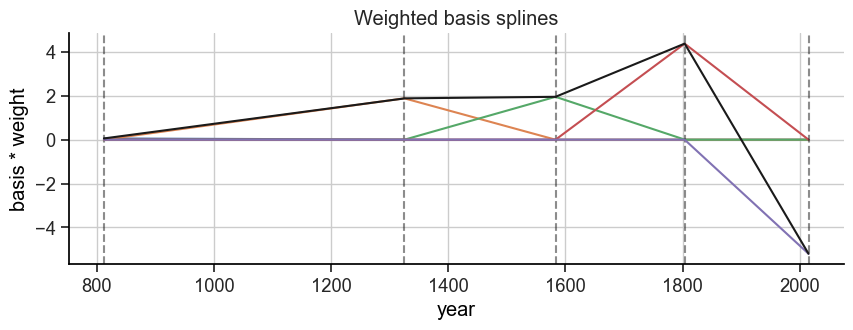

In [314]:
plot_weighted_splines(model, cherry, knots);

Finally we find the posterior mean and a HDI for mu and plot it alongside the original data

In [315]:
def plot_splines_mean_and_posterior_hdi(trace, cherry, hdi_prob=0.89, ax=None):
    mu_mean = trace.posterior.mu.mean(dim=["chain", "draw"])
    mu_hdi = az.hdi(trace.posterior.mu, hdi_prob=0.89)

    mu_plot_data = pd.DataFrame(
        {
            "year": trace.constant_data.year,
            "mean": mu_mean,
            "hdi_lower": mu_hdi.mu.sel(hdi="lower"),
            "hdi_higher": mu_hdi.mu.sel(hdi="higher"),
        }
    ).sort_values("year")
    
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 4))

    # plot true data
    sns.scatterplot(cherry, x="year", y="doy", ax=ax)

    # plot the mean estimates
    ax.plot(
        mu_plot_data["year"],
        mu_plot_data["mean"],
        color="k"
    )

    # posterior HDI
    ax.fill_between(
        mu_plot_data["year"],
        mu_plot_data["hdi_lower"],
        mu_plot_data["hdi_higher"],
        color="k",
        alpha=0.5,
    )

    ax.set(ylabel="Day of year", title="Day of first cherry blossom");

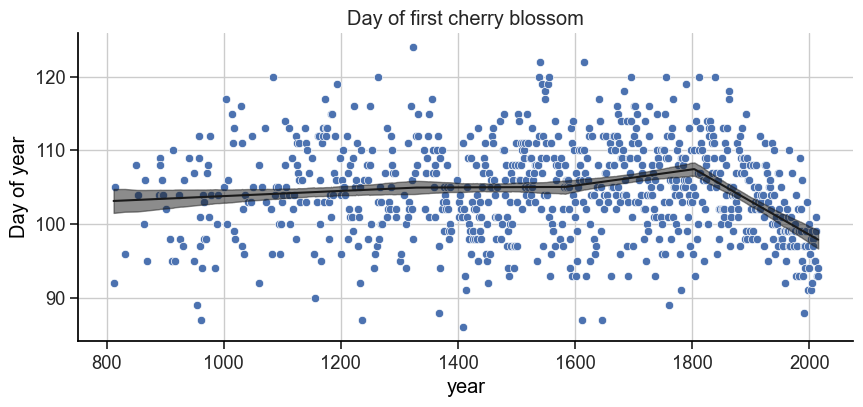

In [316]:
plot_splines_mean_and_posterior_hdi(trace_4_7a, cherry)

Now let's repeat that with different numbers of splines and knots.

In [356]:
def fit_and_plot_spline_model(cherry, n_knots, deg):
    fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(9, 9))

    design_matrix, knots = generate_design_matrix(cherry, n_knots, deg)
    plot_basis_splines(cherry, design_matrix, knots, ax=axs[0])

    # get the model
    model = define_linear_spline_model(cherry, design_matrix)
    trace = plot_weighted_splines(model, cherry, knots, ax=axs[1])

    # plot the predictions
    plot_splines_mean_and_posterior_hdi(trace, cherry, ax=axs[2])

    for ax in axs:
        ax.set(xlabel=None, title=None)
    
    axs[2].set(xlabel="year")
    
    fig.suptitle(f"Degree {deg} basis splines with {n_knots} knots")
    plt.tight_layout();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


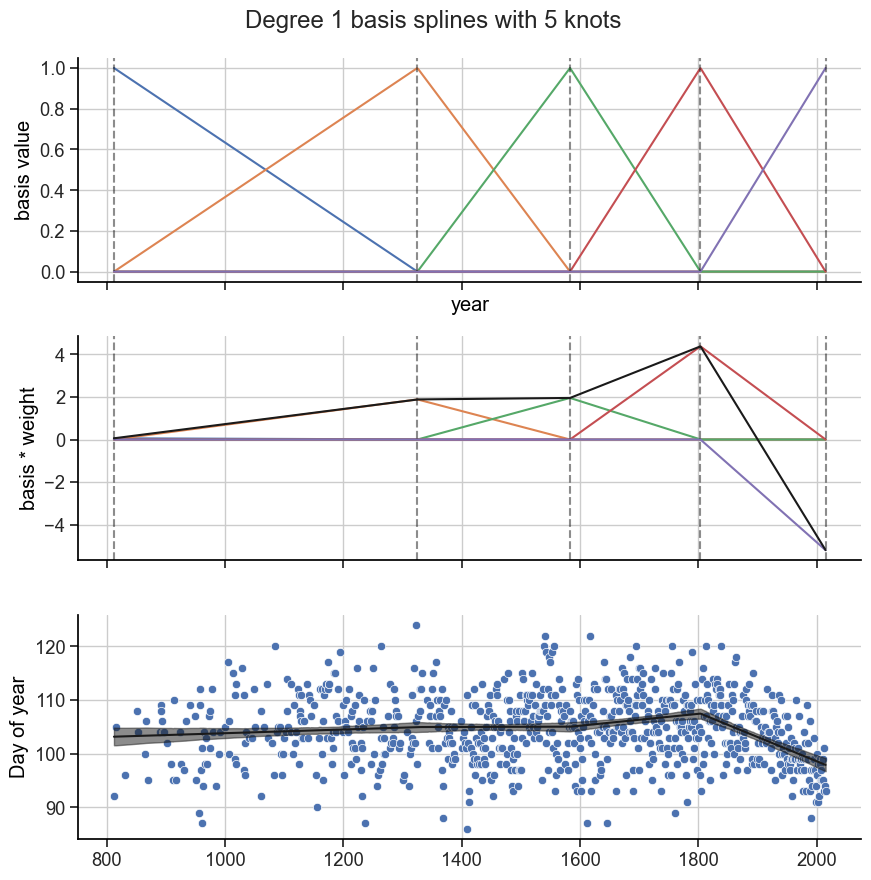

In [352]:
fit_and_plot_spline_model(cherry, n_knots=5, deg=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


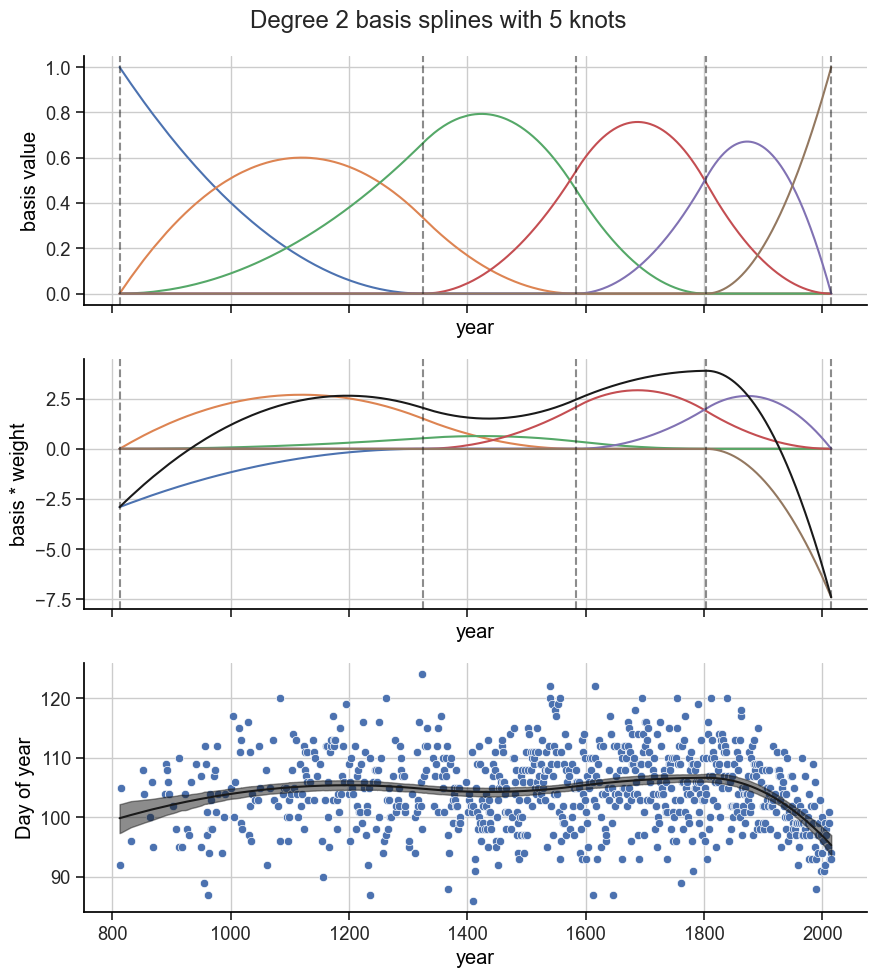

In [353]:
fit_and_plot_splines(cherry, n_knots=5, deg=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


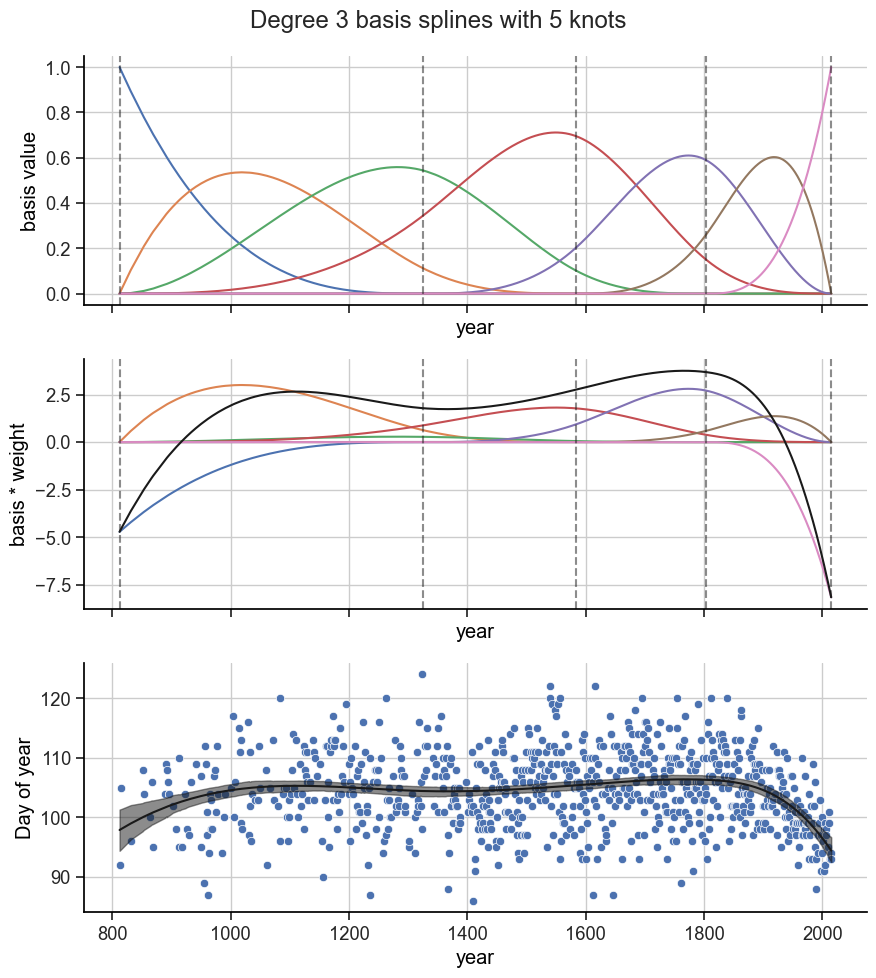

In [354]:
fit_and_plot_splines(cherry, n_knots=5, deg=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


ValueError: Not enough samples to build a trace.

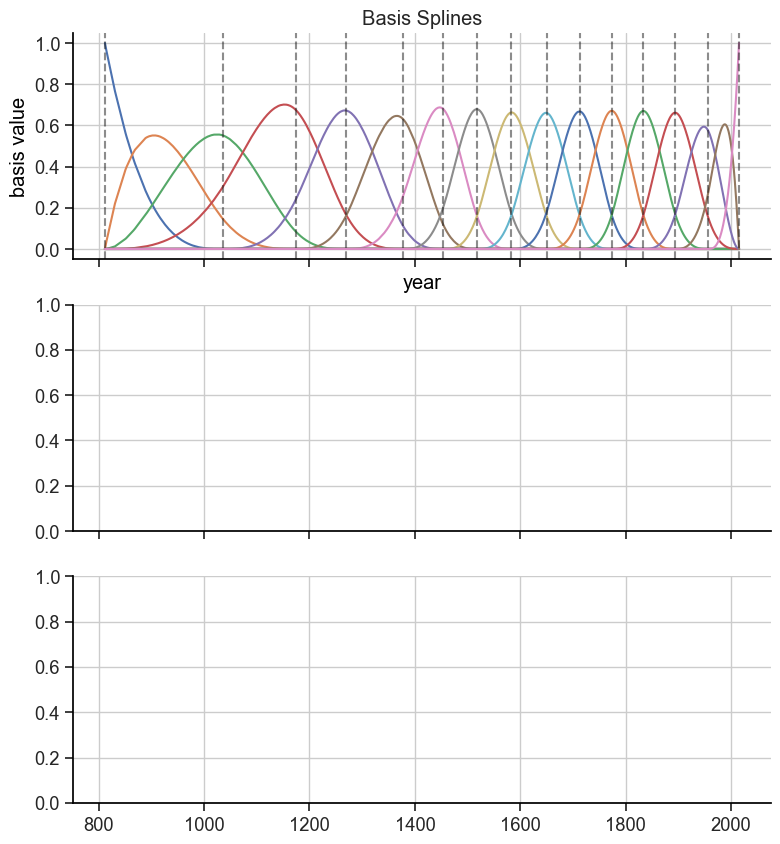

In [357]:
fit_and_plot_splines(cherry, n_knots=15, deg=3)

# Exercises

## Easy

### 4E1

In the model definition below, which line is the likelihood?

\begin{align}
    y_i & \sim \text{Normal}\left( \mu, \sigma\right) \\
    \mu & \sim \text{Normal}\left( 0, 10\right) \\
    \sigma & \sim \text{Exponential}\left( 1\right).
\end{align}

---

The first line.

### 4E2

In the model definition just above, how many parameters are in the posterior distribution.

---

Two: $\mu$ and $\sigma$.

### 4E3

Using the model definition above, write down the appropriate form of Bayes' theorem that includes the proper likelihood and priors.

---